# Imports

In [13]:
#TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#Pandas, NumPy, and MatPlotLibs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#SkLearn, MlXtend
import sklearn
from sklearn import preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, average_precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.classifier import EnsembleVoteClassifier

#Reading datafile
data = pd.read_csv("newData.csv", delimiter = ',')

#Defining the data without the target label
dataSkills = data[['Attack', 'Defence', 'Strength', 'Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting', 'Fletching',
              'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining', 'Herblore', 'Agility', 'Thieving', 'Slayer', 'Farming',
              'Runecraft', 'Hunter', 'Construction', 'Total', 'BountyHunter', 'BountyRogue', 'AllClues', 'LMSRank', 'Zeal', 'AbyssalSire', 'AlchemicalHydra', 'Barrows',
              'Bryophyta', 'Callisto', 'Cerberus', 'Xeric', 'XericHard', 'Elemental', 'Fanatic', 'Zilyana', 'Corp', 
              'CrazyArchaeologist', 'Prime', 'Rex', 'Supreme', 'DerangedArchaeologist', 'Graardor', 'Mole', 'Gargoyles',
              'Hespori', 'Queen', 'KBD', 'Kraken', 'Kree', 'Kril', 'Mimic', 'Nightmare', 'Obor', 'Sarachnis', 'Scorpia',
              'Skotizo', 'Gauntlet', 'CorruptedGauntlet', 'Theatre', 'SmokeDevil', 'Zuk', 'Jad', 'Venenatis', 'Vetion', 
              'Vorkath', 'Wintertodt', 'Zalcano', 'Zulrah', 'Bot']]

#Putting data into seperate variables for features and labels
x = data.values[:, 1:76]
y = data.values[:, 76]

#Defining their type because it breaks when I don't
x = np.asarray(x).astype('float32')
y = np.array(y).astype(int)

min_max_scaler = preprocessing.MinMaxScaler()
x_scale = min_max_scaler.fit_transform(x)

#Splitting into 80% training 20% testing
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.2, shuffle=True)

## Functions

In [8]:
def build_kerasEnsemble():
    model= Sequential([
        Dense(500, activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dropout(.1),
        Dense(1, activation='sigmoid')
])
    model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

def dftods(data, shuffle=True, batch_size=64):
    data = data.copy()
    labels = data.pop('Bot')
    ds = tf.data.Dataset.from_tensor_slices((dict(data), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))
    ds = ds.batch(batch_size)
    return ds

def make_confusionmatrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm1 = ConfusionMatrixDisplay(cm).plot()
    
#Solo Keras Functions

def train_model(model, training, validation, epochs):
    history = model.fit(training,
                        validation_data=validation,
                        epochs=epochs)
    return history

def graph_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def graph_modelSci(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def build_kerasSolo(featurelayer):
    model= Sequential([
        featurelayer,
        Dense(5000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(500, activation='relu'),
        Dropout(.1),
        Dense(1,activation='sigmoid')
])
    model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Keras Models

Train for 328 steps, validate for 82 steps
Epoch 1/5
328/328 [==============================] - 10s 31ms/step - loss: 89017.2846 - accuracy: 0.7530 - val_loss: 2027.3717 - val_accuracy: 0.8432
Epoch 2/5
328/328 [==============================] - 9s 29ms/step - loss: 1550.6566 - accuracy: 0.8044 - val_loss: 744.2411 - val_accuracy: 0.7578
Epoch 3/5
328/328 [==============================] - 10s 30ms/step - loss: 290.3923 - accuracy: 0.8287 - val_loss: 48.9293 - val_accuracy: 0.8406
Epoch 4/5
328/328 [==============================] - 10s 29ms/step - loss: 30.2166 - accuracy: 0.8270 - val_loss: 26.5357 - val_accuracy: 0.8333
Epoch 5/5
328/328 [==============================] - 10s 29ms/step - loss: 27.0405 - accuracy: 0.8241 - val_loss: 28.5185 - val_accuracy: 0.8330


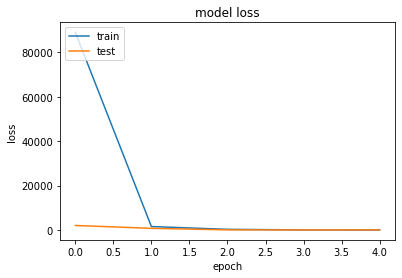

103/103 [==============================] - 1s 5ms/step - loss: 87.6607 - accuracy: 0.8331
Loss 87.66074530375235
Accuracy 0.83307904


In [11]:
# ========== NON-PROCESSED SKILLS DATA ==========

#Splitting data into train test and val, 80% training 20% testing / val
train, test = train_test_split(dataSkills, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

feature_columns = []
for header in ['Attack', 'Defence', 'Strength', 'Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting', 'Fletching',
              'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining', 'Herblore', 'Agility', 'Thieving', 'Slayer', 'Farming',
              'Runecraft', 'Hunter', 'Construction', 'Total']:
    feature_columns.append(feature_column.numeric_column(header))
    
#Inputting the feature columns into the Keras neural network using a dense features layer.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#Converting data into a Keras-readable format
batch_size = 32
train_ds = dftods(train, batch_size=batch_size)
val_ds = dftods(val, shuffle=False, batch_size=batch_size)
test_ds = dftods(test, shuffle=False, batch_size=batch_size)

#Building, training, and graphing the models results
clf = build_kerasSolo(feature_layer)
history = train_model(clf, train_ds, val_ds, 5)
graph_model(history)

#Printing the test evaluation
loss, accuracy = clf.evaluate(test_ds)
print("Loss", loss)
print("Accuracy", accuracy)

Train for 328 steps, validate for 82 steps
Epoch 1/10
328/328 [==============================] - 12s 35ms/step - loss: 88053.6481 - accuracy: 0.7495 - val_loss: 5563.6999 - val_accuracy: 0.7963
Epoch 2/10
328/328 [==============================] - 10s 30ms/step - loss: 1712.0617 - accuracy: 0.8045 - val_loss: 635.8328 - val_accuracy: 0.8284
Epoch 3/10
328/328 [==============================] - 10s 30ms/step - loss: 681.3348 - accuracy: 0.8340 - val_loss: 551.5376 - val_accuracy: 0.8402
Epoch 4/10
328/328 [==============================] - 10s 29ms/step - loss: 234.7770 - accuracy: 0.8328 - val_loss: 24.8641 - val_accuracy: 0.8402
Epoch 5/10
328/328 [==============================] - 10s 29ms/step - loss: 189.9261 - accuracy: 0.8215 - val_loss: 174.6906 - val_accuracy: 0.8413
Epoch 6/10
328/328 [==============================] - 10s 30ms/step - loss: 26.5642 - accuracy: 0.8297 - val_loss: 0.8657 - val_accuracy: 0.8284
Epoch 7/10
328/328 [==============================] - 10s 30ms/step -

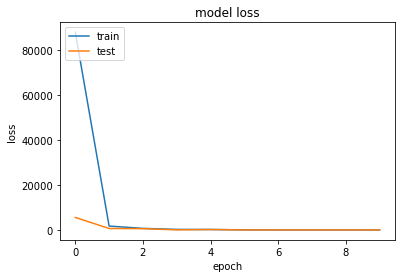

103/103 [==============================] - 1s 6ms/step - loss: 10.4510 - accuracy: 0.8401
Loss 10.451040566546245
Accuracy 0.84009767


In [109]:
# ========== NON-PROCESSED ALL DATA ==========

#Splitting data into test and train on a 4:1 ratio
train, test = train_test_split(dataSkills, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

#Making the feature columns to put into the neural network as a layer
feature_columns = []
for header in ['Attack', 'Defence', 'Strength', 'Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting', 'Fletching',
              'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining', 'Herblore', 'Agility', 'Thieving', 'Slayer', 'Farming',
              'Runecraft', 'Hunter', 'Construction', 'Total', 'BountyHunter', 'BountyRogue', 'AllClues', 'LMSRank', 'Zeal', 'AbyssalSire', 'AlchemicalHydra', 'Barrows',
              'Bryophyta', 'Callisto', 'Cerberus', 'Xeric', 'XericHard', 'Elemental', 'Fanatic', 'Zilyana', 'Corp', 
              'CrazyArchaeologist', 'Prime', 'Rex', 'Supreme', 'DerangedArchaeologist', 'Graardor', 'Mole', 'Gargoyles',
              'Hespori', 'Queen', 'KBD', 'Kraken', 'Kree', 'Kril', 'Mimic', 'Nightmare', 'Obor', 'Sarachnis', 'Scorpia',
              'Skotizo', 'Gauntlet', 'CorruptedGauntlet', 'Theatre', 'SmokeDevil', 'Zuk', 'Jad', 'Venenatis', 'Vetion', 
              'Vorkath', 'Wintertodt', 'Zalcano', 'Zulrah']:
    feature_columns.append(feature_column.numeric_column(header))

#Defining the feature columns as a layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#Converting data into Keras accepted data structures
batch_size = 32
train_ds = dftods(train, batch_size=batch_size)
val_ds = dftods(val, shuffle=False, batch_size=batch_size)
test_ds = dftods(test, shuffle=False, batch_size=batch_size)

#Building, training and graphing the model
bothData = build_kerasSolo(feature_layer)
bothDataHistory = train_model(bothData, train_ds, val_ds, 10)
graph_model(bothDataHistory)

#Printing the evaluation to avoid overfitting, false statistics etc.
loss, accuracy = bothData.evaluate(test_ds)
print("Loss", loss)
print("Accuracy", accuracy)

Accuracy :  0.9981690570643882
Precision :  0.9992896222588451


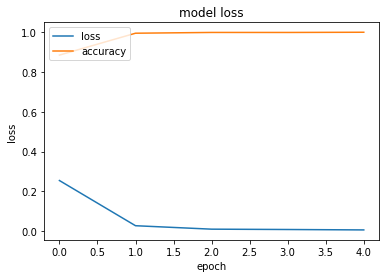

              precision    recall  f1-score   support

 Real_Player       0.99      1.00      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



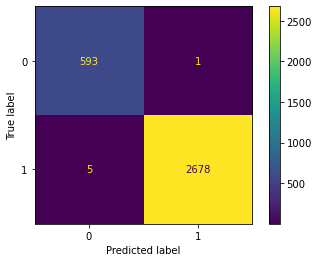

In [15]:
# ========== PRE-PROCESSED DATA ==========

#Defining the Keras classifier using the function defined at the beginning of the notebook
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_kerasEnsemble,
                            epochs=5,
                            verbose=False)

#SciKit wants to know its a classifier
keras_clf._estimator_type = "classifier"

#Training the model
keras_clf.fit(X_train, y_train)
history = keras_clf.fit(X_train, y_train)

#Predicting the test data portion
y_pred = keras_clf.predict(X_test)
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", average_precision_score(y_test, y_pred))

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

#Making a classification report and confusion matrix to check for overfitting etc.
target_names = ['Real_Player', 'Bot']
print(classification_report(y_test, keras_clf.predict(X_test), target_names=target_names))
make_confusionmatrix(keras_clf, X_test, y_test)

# SciKit Ensemble Learning (KNN, MLP, Keras)

KNeighborsClassifier
Accuracy :  0.9563625267012511
Precision :  0.9645478075126859
              precision    recall  f1-score   support

 Real_Player       0.90      0.85      0.88       594
         Bot       0.97      0.98      0.97      2683

    accuracy                           0.96      3277
   macro avg       0.93      0.92      0.92      3277
weighted avg       0.96      0.96      0.96      3277



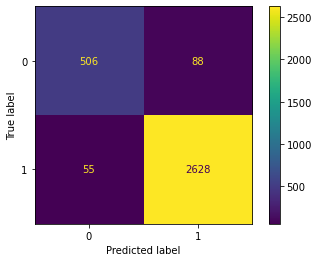

MLPClassifier
Accuracy :  0.9969484284406469
Precision :  0.9990193826597635
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       0.99      1.00      0.99      3277
weighted avg       1.00      1.00      1.00      3277



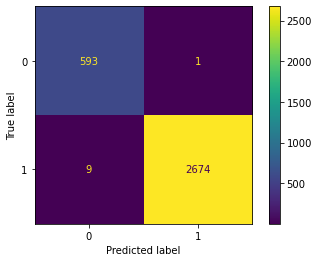

KerasClassifier
Accuracy :  0.9984742142203235
Precision :  0.999052441808585
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      1.00       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



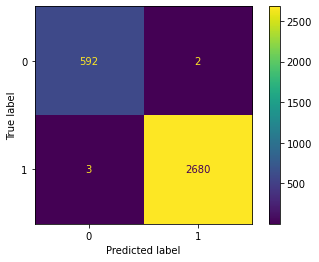

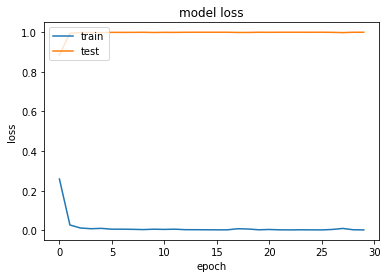

VotingClassifier
Accuracy :  0.9987793713762587
Precision :  0.9997297601928803
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      1.00       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



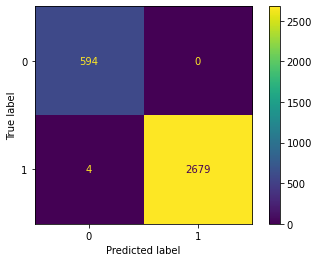

In [18]:
# ========== SCI-KIT ENSEMBLE PRE-PROCESSED DATA ==========

#Defining the Keras classifier using the function from above
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_kerasEnsemble,
                            epochs=30,
                            verbose=False)

#SciKit wants to know its a classifier
keras_clf._estimator_type = "classifier"

#Defining the other SciKit classifiers
knn_clf = KNeighborsClassifier(n_neighbors=3)
mlp_clf = MLPClassifier(random_state=7, max_iter=500)

#Sci-Kit voting classifier
voting = VotingClassifier(
             estimators=[('knn', knn_clf),
                         ('mlp', mlp_clf),
                         ('keras', keras_clf)], 
             voting='soft',
             flatten_transform=True)

#Target names for cleaner results
target_names = ['Real_Player', 'Bot']

#Training and evaluating all the models, with confusion matrix
for clf in (knn_clf, mlp_clf, keras_clf, voting):
    history = clf.fit(X_train, y_train) # Making a fit history, bit messy
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) # Making a prediction into a variable
    print(clf.__class__.__name__) # Printing the name of the classifier in the loop
    print("Accuracy : ", accuracy_score(y_test, y_pred)) # Printing Precision and accuracy
    print("Precision : ", average_precision_score(y_test, y_pred))
    print(classification_report(y_test, clf.predict(X_test), target_names=target_names)) # Making a classification report
    make_confusionmatrix(clf, X_test, y_test) # Making a confusion matrix
    plt.show() # Plt.show() makes the confusion matrix show up (otherwise it gets stuck with the graph)
    if(clf == keras_clf): # Plotting the Keras graph
        plt.plot(history.history['loss'])
        plt.plot(history.history['accuracy'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

# SciKit Ensemble Learning (Random Forest, Extra Trees)

RandomForestClassifier
Accuracy :  0.9966432712847116
Precision :  0.9977345289967147
              precision    recall  f1-score   support

 Real_Player       0.99      0.99      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       0.99      0.99      0.99      3277
weighted avg       1.00      1.00      1.00      3277



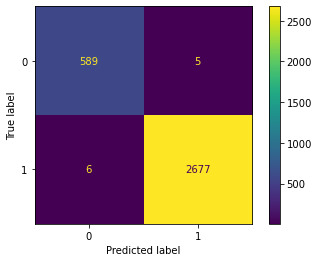

ExtraTreesClassifier
Accuracy :  0.9987793713762587
Precision :  0.9997297601928803
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      1.00       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



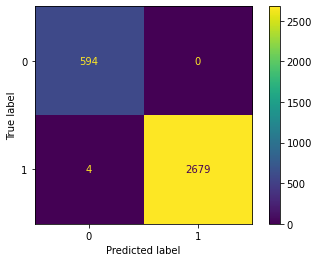

VotingClassifier
Accuracy :  0.9981690570643882
Precision :  0.9989848820641454
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



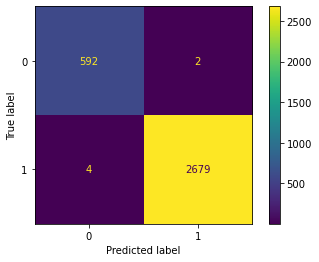

In [30]:
# ========== RANDOM FORESTS PRE-PROCESSED DATA ==========

#Defining the random forests
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=7)
extrnd_clf = ExtraTreesClassifier(n_estimators=100, random_state=7)

#Ensembling them
both_clf = VotingClassifier(
             estimators=[('randomforest', rnd_clf),
                         ('extrarandom', extrnd_clf)],
             voting='soft',
             flatten_transform=True)

#Training evaluating and graphing the models.
for clf in (rnd_clf, extrnd_clf, both_clf):
    clf.fit(X_train, y_train) # Fitting the model
    y_pred = clf.predict(X_test) # Prediction
    print(clf.__class__.__name__) # Classifier name print
    print("Accuracy : ", accuracy_score(y_test, y_pred)) # Accuracy and precision of prediction
    print("Precision : ", average_precision_score(y_test, y_pred))
    print(classification_report(y_test, clf.predict(X_test), target_names=target_names)) # Classification report
    make_confusionmatrix(clf, X_test, y_test) # Confusion matrix
    plt.show()

# Mlxtend Ensemble Learning (KNN, MLP, Keras)

In [153]:
# ========== SCI-KIT ENSEMBLE PRE-PROCESSED DATA ==========

#Defining the Keras classifier using the function from above
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_kerasEnsemble,
                            epochs=30,
                            verbose=False)

#SciKit wants to know its a classifier
keras_clf._estimator_type = "classifier"

#Defining the other SciKit classifiers
knn_clfml = KNeighborsClassifier(n_neighbors=3)
mlp_clfml = MLPClassifier(random_state=42, max_iter=500)

#Mlxtend voting classifier
eclf = EnsembleVoteClassifier(clfs=[knn_clf, mlp_clf, keras_clf], voting="soft", weights=[1,1,1])

#Getting a cross validated score for each classifier
labels = ['KNN', 'MLP', 'Keras', 'Ensemble']
for clf, label in zip([knn_clfml, mlp_clfml, keras_clf, eclf], labels):

    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.00) [KNN]
Accuracy: 1.00 (+/- 0.00) [MLP]
Accuracy: 1.00 (+/- 0.00) [Keras]
Accuracy: 1.00 (+/- 0.00) [Ensemble]


# Mlxtend Ensemble Learning (Random Forest, Extra Trees)

In [5]:
# ========== SCI-KIT ENSEMBLE PRE-PROCESSED DATA ==========

#Defining the random forests
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=7)
extrnd_clf = ExtraTreesClassifier(n_estimators=100, random_state=7)

#Mlxtend voting classifier
eclf = EnsembleVoteClassifier(clfs=[rnd_clf, extrnd_clf], voting="soft", weights=[1,2])

#Getting a cross validated score for each classifier
labels = ['Random Forest', 'Extra Trees', 'Ensemble']
for clf, label in zip([rnd_clf, extrnd_clf, eclf], labels):

    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.99 (+/- 0.00) [Random Forest]
Accuracy: 1.00 (+/- 0.00) [Extra Trees]
Accuracy: 1.00 (+/- 0.00) [Ensemble]


ExtraTreesClassifier
Accuracy :  0.9987793713762587
Precision :  0.9997297601928803
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      1.00       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



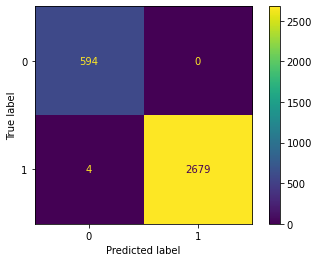

KerasClassifier
Accuracy :  0.9972535855965823
Precision :  0.9978696463114176
              precision    recall  f1-score   support

 Real_Player       0.99      0.99      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



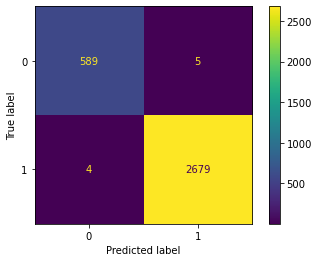

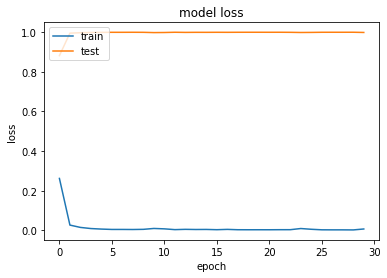

MLPClassifier
Accuracy :  0.9969484284406469
Precision :  0.9990193826597635
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      0.99       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       0.99      1.00      0.99      3277
weighted avg       1.00      1.00      1.00      3277



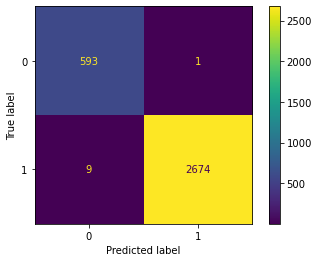

VotingClassifier
Accuracy :  0.9987793713762587
Precision :  0.9997297601928803
              precision    recall  f1-score   support

 Real_Player       0.99      1.00      1.00       594
         Bot       1.00      1.00      1.00      2683

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



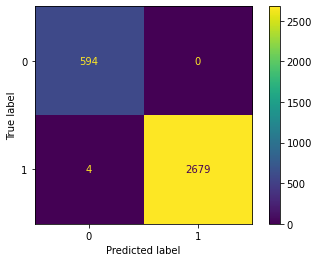

In [34]:
extrnd_clf = ExtraTreesClassifier(n_estimators=100, random_state=7)
mlp_clf = MLPClassifier(random_state=7, max_iter=500)

#Defining the Keras classifier using the function from above
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_kerasEnsemble,
                            epochs=30,
                            verbose=False)

#SciKit wants to know its a classifier
keras_clf._estimator_type = "classifier"

#Target names for cleaner results
target_names = ['Real_Player', 'Bot']

#Sci-Kit voting classifier
voting = VotingClassifier(
             estimators=[('extra', extrnd_clf),
                         ('mlp', mlp_clf),
                         ('keras', keras_clf)], 
             voting='soft',
             flatten_transform=True)

#Training and evaluating all the models, with confusion matrix
for clf in (extrnd_clf, keras_clf, mlp_clf, voting):
    history = clf.fit(X_train, y_train) # Making a fit history, bit messy
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) # Making a prediction into a variable
    print(clf.__class__.__name__) # Printing the name of the classifier in the loop
    print("Accuracy : ", accuracy_score(y_test, y_pred)) # Printing Precision and accuracy
    print("Precision : ", average_precision_score(y_test, y_pred))
    print(classification_report(y_test, clf.predict(X_test), target_names=target_names)) # Making a classification report
    make_confusionmatrix(clf, X_test, y_test) # Making a confusion matrix
    plt.show() # Plt.show() makes the confusion matrix show up (otherwise it gets stuck with the graph)
    if(clf == keras_clf): # Plotting the Keras graph
        plt.plot(history.history['loss'])
        plt.plot(history.history['accuracy'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()